## Gaussian Processes Regression
## Gabriel Marcelino, Eli Kaustinen


## Load and Visualize Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C


# Load the dataset
file_path = "GSE102560_brg_all.csv"  # Update with the correct path if needed
df = pd.read_csv(file_path)

# Display basic info
print(df.info())
print(df.head())
print(df.columns)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35012 entries, 0 to 35011
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   rowname         35012 non-null  object 
 1   baseMean        35012 non-null  float64
 2   log2FoldChange  24624 non-null  float64
 3   lfcSE           24624 non-null  float64
 4   stat            24624 non-null  float64
 5   pvalue          24611 non-null  float64
 6   padj            16210 non-null  float64
dtypes: float64(6), object(1)
memory usage: 1.9+ MB
None
  rowname      baseMean  log2FoldChange     lfcSE      stat        pvalue  \
0    A1BG    108.080568       -1.619207  0.448076 -3.613689  3.018706e-04   
1    A1CF   2027.753935       -1.036464  0.266051 -3.895741  9.789908e-05   
2     A2M  47785.656427       -2.238095  0.401428 -5.575340  2.470466e-08   
3   A2ML1      2.016858        0.681006  1.065578  0.639095  5.227611e-01   
4   A2MP1      0.098283       -0.516357  4.20

## Filter for Differentially Expressed Genes

In [2]:
df_sig = df[df["padj"] < 0.05]
print(f"Number of significant genes: {df_sig.shape[0]}")


Number of significant genes: 3987


## Gaussian Process Regression (GPR)

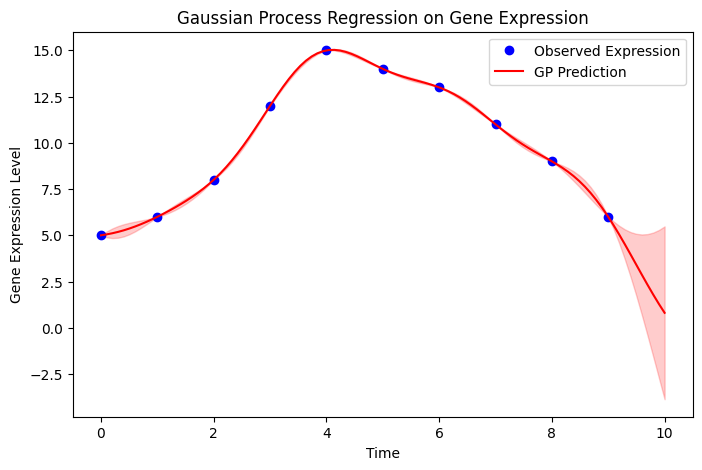

In [ ]:

# Simulated time-series data for a gene
time_points = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])  # Time points
expression_levels = np.array([5, 6, 8, 12, 15, 14, 13, 11, 9, 6])  # Simulated expression

# Reshape for sklearn
X = time_points.reshape(-1, 1)
y = expression_levels

# Define the GP model
kernel = C(1.0) * RBF(length_scale=1.0)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# Fit the model
gp.fit(X, y)

# Predict across time range
X_pred = np.linspace(0, 10, 100).reshape(-1, 1)
y_pred, sigma = gp.predict(X_pred, return_std=True)

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(time_points, expression_levels, 'bo', label="Observed Expression")
plt.plot(X_pred, y_pred, 'r-', label="GP Prediction")
plt.fill_between(X_pred.ravel(), y_pred - 1.96 * sigma, y_pred + 1.96 * sigma, color='red', alpha=0.2)
plt.xlabel("Time")
plt.ylabel("Gene Expression Level")
plt.legend()
plt.title("Gaussian Process Regression on Gene Expression")
plt.show()
